In [1]:
# ============================================================
# 🧭 Mine Worker Tracking & Safety Map Prototype
# ------------------------------------------------------------
# Author: Monday Oloche Obaa
# Description:
#   This notebook simulates BLE-based worker tracking inside a mine.
#   It visualizes beacon signals, performs trilateration, and
#   estimates worker positions for safety monitoring.
# ------------------------------------------------------------
# Environment: Google Colab / Jupyter Notebook
# ============================================================

# --- Standard Library ---
import math
import random
import json
import time
from datetime import datetime
from typing import Dict, List, Tuple

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Plotting & Visualization ---
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# --- System / Utilities ---
import os
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Random Seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Global Plot Style Configuration ---
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.family": "DejaVu Sans",
})

# --- Package Check Message ---
print("✅ Environment initialized successfully!")
print("Packages imported:")
print("  • numpy, pandas, matplotlib, animation, json, random, etc.")
print("Random seed set to:", SEED)

# --- Optional utility: Start timer for notebook runtime measurement ---
NOTEBOOK_START = time.time()

def notebook_runtime():
    """Return elapsed time since notebook start."""
    return f"{time.time() - NOTEBOOK_START:.2f} sec"

# Example run-time check
print("Notebook start time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


✅ Environment initialized successfully!
Packages imported:
  • numpy, pandas, matplotlib, animation, json, random, etc.
Random seed set to: 42
Notebook start time: 2025-11-11 22:44:52


✅ Synthetic worker dataset generated successfully!
File saved as: workers.csv
Number of workers: 100

Sample of generated data:

  worker_id      x      y
0        W1  12.79   0.23
1        W2   0.50  14.41
2        W3   5.50  13.63
3        W4   4.46  10.74
4        W5  14.73   5.34


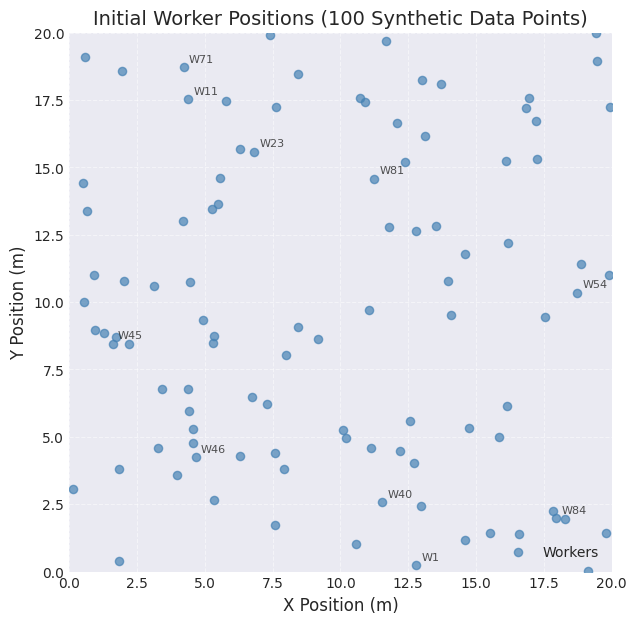

In [2]:
# ============================================================
# Generate and Load Synthetic Worker Data (100 Workers)
# ------------------------------------------------------------
# This task creates a synthetic dataset of 100 mine workers.
# Each worker is assigned a unique ID and random (x, y)
# coordinates within the defined mine area.
# The dataset will be saved as 'workers.csv' and later used
# for BLE signal simulation and real-time tracking visualization.
# ============================================================

import pandas as pd
import random
import matplotlib.pyplot as plt

# --- Configuration ---
NUM_WORKERS = 100            # Total number of simulated mine workers
MAP_WIDTH = 20.0             # Width of mine area (meters)
MAP_HEIGHT = 20.0            # Height of mine area (meters)
CSV_FILENAME = "workers.csv"

# --- Generate synthetic worker positions ---
workers_data = {
    "worker_id": [f"W{i+1}" for i in range(NUM_WORKERS)],
    "x": [round(random.uniform(0, MAP_WIDTH), 2) for _ in range(NUM_WORKERS)],
    "y": [round(random.uniform(0, MAP_HEIGHT), 2) for _ in range(NUM_WORKERS)],
}

# --- Convert to DataFrame ---
workers_df = pd.DataFrame(workers_data)

# --- Save to CSV file ---
workers_df.to_csv(CSV_FILENAME, index=False)

# --- Display summary information ---
print("✅ Synthetic worker dataset generated successfully!")
print(f"File saved as: {CSV_FILENAME}")
print(f"Number of workers: {NUM_WORKERS}")
print("\nSample of generated data:\n")
print(workers_df.head())

# --- Visualization (Optional Preview) ---
plt.figure(figsize=(7, 7))
plt.scatter(workers_df["x"], workers_df["y"], c="steelblue", s=35, label="Workers", alpha=0.7)
for _, row in workers_df.sample(10).iterrows():  # show only a few labels for clarity
    plt.text(row["x"] + 0.2, row["y"] + 0.2, row["worker_id"], fontsize=8, alpha=0.8)
plt.xlim(0, MAP_WIDTH)
plt.ylim(0, MAP_HEIGHT)
plt.title("Initial Worker Positions (100 Synthetic Data Points)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [3]:
# ============================================================
# Define Beacon Class and Signal Simulation
# ------------------------------------------------------------
# This section defines the Beacon class and simulates Bluetooth
# signal strength (RSSI) values for workers located inside the mine.
# The beacons serve as fixed reference points with known coordinates.
# ============================================================

import math
import numpy as np

# --- Beacon Class Definition ---
class Beacon:
    """
    Represents a BLE Beacon with a fixed position in the mine.
    The beacon transmits signal strength (RSSI) values that
    decrease with distance according to the log-distance path loss model.
    """
    def __init__(self, beacon_id: str, x: float, y: float, tx_power: int = -59, path_loss_exp: float = 2.0):
        self.beacon_id = beacon_id     # Unique identifier for the beacon
        self.x = x                     # X coordinate (meters)
        self.y = y                     # Y coordinate (meters)
        self.tx_power = tx_power       # Signal strength (dBm) at 1 meter
        self.path_loss_exp = path_loss_exp  # Path loss exponent (environment factor)

    def distance_to(self, x: float, y: float) -> float:
        """Calculate Euclidean distance from beacon to a given (x, y) position."""
        return math.sqrt((self.x - x)**2 + (self.y - y)**2)

    def generate_rssi(self, x: float, y: float, noise_std: float = 2.0) -> float:
        """
        Simulate RSSI value for a worker located at (x, y).
        Adds Gaussian noise to model real-world signal variation.
        Formula: RSSI = tx_power - 10 * n * log10(distance)
        """
        distance = self.distance_to(x, y)
        if distance < 1e-4:  # avoid log(0)
            distance = 1e-4
        rssi = self.tx_power - 10 * self.path_loss_exp * math.log10(distance)
        noisy_rssi = rssi + np.random.normal(0, noise_std)
        return round(noisy_rssi, 2)

# --- Create Beacons in the Mine ---
# Define four corner beacons to cover the 20x20 mine area.
beacons = [
    Beacon("B1", 0, 0),
    Beacon("B2", 20, 0),
    Beacon("B3", 0, 20),
    Beacon("B4", 20, 20)
]

print("✅ Beacons initialized successfully!")
for b in beacons:
    print(f"{b.beacon_id}: ({b.x}, {b.y}) | TX Power: {b.tx_power} dBm")

# --- Simulate RSSI Values for a Few Workers ---
sample_workers = workers_df.sample(20, random_state=SEED)
print("\n📡 Example RSSI readings for 20 random workers:\n")

for _, worker in sample_workers.iterrows():
    rssi_data = {b.beacon_id: b.generate_rssi(worker.x, worker.y) for b in beacons}
    print(f"{worker.worker_id} @ ({worker.x}, {worker.y}) → {rssi_data}")


✅ Beacons initialized successfully!
B1: (0, 0) | TX Power: -59 dBm
B2: (20, 0) | TX Power: -59 dBm
B3: (0, 20) | TX Power: -59 dBm
B4: (20, 20) | TX Power: -59 dBm

📡 Example RSSI readings for 20 random workers:

W84 @ (17.96, 1.97) → {'B1': -82.87, 'B2': -69.87, 'B3': -86.16, 'B4': -81.57}
W54 @ (18.73, 10.35) → {'B1': -85.18, 'B2': -78.17, 'B3': -87.27, 'B4': -78.99}
W71 @ (4.22, 18.71) → {'B1': -81.72, 'B2': -89.02, 'B3': -69.99, 'B4': -79.54}
W46 @ (4.66, 4.24) → {'B1': -74.07, 'B2': -86.4, 'B3': -82.66, 'B4': -86.01}
W45 @ (1.6, 8.46) → {'B1': -76.76, 'B2': -83.66, 'B3': -81.89, 'B4': -87.42}
W40 @ (11.55, 2.57) → {'B1': -80.76, 'B2': -79.85, 'B3': -85.11, 'B4': -84.97}
W23 @ (6.81, 15.57) → {'B1': -78.34, 'B2': -87.25, 'B3': -78.76, 'B4': -81.02}
W81 @ (11.23, 14.58) → {'B1': -82.55, 'B2': -79.04, 'B3': -77.67, 'B4': -77.62}
W11 @ (4.37, 17.52) → {'B1': -83.55, 'B2': -84.62, 'B3': -74.24, 'B4': -83.62}
W1 @ (12.79, 0.23) → {'B1': -84.1, 'B2': -76.62, 'B3': -84.51, 'B4': -85.88}
W

✅ Trilateration complete! Example position estimates:

   worker_id      x      y      est_x      est_y    error_m
83       W84  17.96   1.97  16.635769   5.740365   3.996153
53       W54  18.73  10.35  22.023246  18.368626   8.668554
70       W71   4.22  18.71   5.853647  22.274760   3.921265
45       W46   4.66   4.24   4.899143   7.091887   2.861896
44       W45   1.60   8.46  -3.152319  11.353274   5.563773
39       W40  11.55   2.57  13.281259   8.224575   5.913669
22       W23   6.81  15.57   5.175937  19.423115   4.185290
80       W81  11.23  14.58  13.968203  15.779821   2.989536
10       W11   4.37  17.52  -0.584764  13.598105   6.319094
0         W1  12.79   0.23  16.469773  -7.803550   8.836213
18       W19  16.19  12.18  13.695842   6.822323   5.909782
30       W31  16.14   6.15  19.179342  -1.244865   7.995100
73       W74   6.29  15.69   5.648257  15.260111   0.772424
33       W34  19.46  18.94  32.815976  41.018880  25.804244
90       W91   2.19   8.44   2.878124   9.626

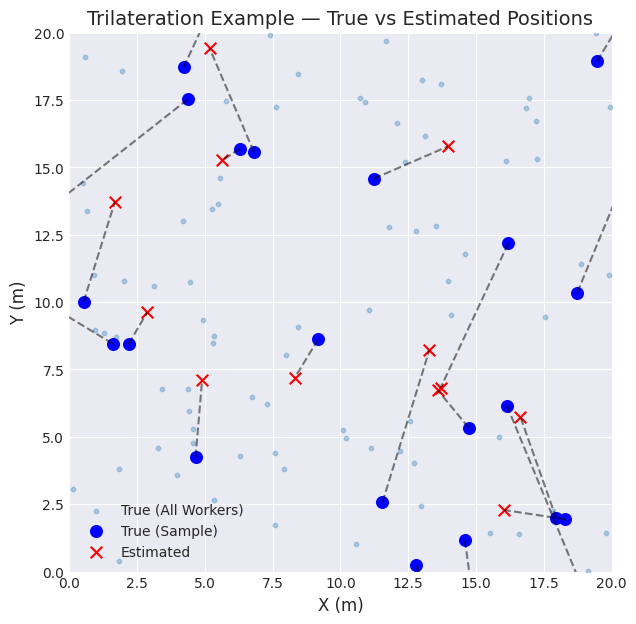

In [4]:
# ============================================================
# Trilateration and Worker Position Estimation
# ------------------------------------------------------------
# Converts RSSI values from multiple beacons to distances,
# then estimates the worker's position using trilateration.
# ============================================================

import numpy as np

# --- Helper Functions ---

def rssi_to_distance(rssi: float, tx_power: float = -59, path_loss_exp: float = 2.0) -> float:
    """
    Convert RSSI value to distance (in meters) using the log-distance model.
    Formula: d = 10 ^ ((TX - RSSI) / (10 * n))
    """
    return 10 ** ((tx_power - rssi) / (10 * path_loss_exp))

def trilaterate(beacon_positions: list, distances: list) -> tuple:
    """
    Estimate (x, y) position from 3+ beacons using least squares trilateration.
    beacon_positions: [(x1, y1), (x2, y2), (x3, y3), ...]
    distances: [d1, d2, d3, ...]
    """
    if len(beacon_positions) < 3:
        raise ValueError("At least 3 beacons are required for trilateration.")

    A = []
    b = []

    # Derive linear equations from the distance equations
    for i in range(1, len(beacon_positions)):
        x1, y1 = beacon_positions[0]
        xi, yi = beacon_positions[i]
        di_sq = distances[i]**2
        d1_sq = distances[0]**2

        A.append([2*(xi - x1), 2*(yi - y1)])
        b.append([d1_sq - di_sq + xi**2 - x1**2 + yi**2 - y1**2])

    A = np.array(A)
    b = np.array(b)

    # Solve using least squares
    position, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return position[0][0], position[1][0]

# --- Simulation: Estimate worker positions from RSSI ---

def estimate_worker_position(worker_row, beacons):
    """Estimate worker position based on simulated RSSI values."""
    # Generate RSSI readings for this worker
    rssi_values = [b.generate_rssi(worker_row.x, worker_row.y) for b in beacons]
    # Convert RSSI to distances
    distances = [rssi_to_distance(rssi, b.tx_power, b.path_loss_exp) for rssi, b in zip(rssi_values, beacons)]
    # Beacon positions
    beacon_positions = [(b.x, b.y) for b in beacons]
    # Estimate position via trilateration
    est_x, est_y = trilaterate(beacon_positions, distances)
    return est_x, est_y

# --- Apply estimation to a few random workers ---
sample_workers = workers_df.sample(20, random_state=SEED).copy()
sample_workers[["est_x", "est_y"]] = sample_workers.apply(lambda w: estimate_worker_position(w, beacons), axis=1, result_type="expand")

# --- Compute and Display Error ---
sample_workers["error_m"] = np.sqrt((sample_workers["x"] - sample_workers["est_x"])**2 + (sample_workers["y"] - sample_workers["est_y"])**2)

print("✅ Trilateration complete! Example position estimates:\n")
print(sample_workers[["worker_id", "x", "y", "est_x", "est_y", "error_m"]])

# --- Visualization ---
plt.figure(figsize=(7, 7))
plt.scatter(workers_df["x"], workers_df["y"], s=10, alpha=0.3, label="True (All Workers)")
plt.scatter(sample_workers["x"], sample_workers["y"], c="blue", s=70, label="True (Sample)")
plt.scatter(sample_workers["est_x"], sample_workers["est_y"], c="red", s=70, marker="x", label="Estimated")

for _, row in sample_workers.iterrows():
    plt.plot([row["x"], row["est_x"]], [row["y"], row["est_y"]], "k--", alpha=0.5)

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title("Trilateration Example — True vs Estimated Positions")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import numpy as np
import pandas as pd

# -------------------------------------------
# Recreate the beacon signal simulation (Task 4)
# -------------------------------------------

# Beacon coordinates (x, y)
beacons = {
    "beacon_1": (0, 0),
    "beacon_2": (10, 0),
    "beacon_3": (5, 8)
}

# Generate synthetic worker data
np.random.seed(42)
num_workers = 100
workers = pd.DataFrame({
    "worker_id": range(1, num_workers + 1),
    "x": np.random.uniform(0, 10, num_workers),
    "y": np.random.uniform(0, 8, num_workers)
})

# Simulate RSSI for each beacon
def simulate_rssi(tx_power=-59, distance=1, n=3, noise=2):
    rssi = tx_power - 10 * n * np.log10(distance)
    rssi += np.random.normal(0, noise)  # add some random noise
    return round(rssi, 2)

# Compute distances & RSSI values for each worker-beacon pair
beacon_signals = workers.copy()
for name, (bx, by) in beacons.items():
    distances = np.sqrt((workers["x"] - bx) ** 2 + (workers["y"] - by) ** 2)
    beacon_signals[f"{name}_rssi"] = distances.apply(
        lambda d: simulate_rssi(distance=d)
    )

# -------------------------------------------
# Task 5: Estimate Distances from RSSI Values
# -------------------------------------------

TX_POWER = -59  # RSSI at 1 meter
PATH_LOSS_EXPONENT = 3.0  # typical for underground mines

def estimate_distance(rssi, tx_power=TX_POWER, n=PATH_LOSS_EXPONENT):
    """Estimate distance from RSSI using log-distance path loss model"""
    distance = 10 ** ((tx_power - rssi) / (10 * n))
    return round(distance, 2)

# Apply function to all beacons
for col in ['beacon_1_rssi', 'beacon_2_rssi', 'beacon_3_rssi']:
    dist_col = col.replace('rssi', 'distance')
    beacon_signals[dist_col] = beacon_signals[col].apply(estimate_distance)

# Preview
print("Sample of Estimated Distances (meters):")
print(beacon_signals.head(10))


Sample of Estimated Distances (meters):
   worker_id         x         y  beacon_1_rssi  beacon_2_rssi  beacon_3_rssi  \
0          1  3.745401  0.251433         -77.59         -78.65         -84.13   
1          2  9.507143  5.091283         -89.52         -78.20         -81.21   
2          3  7.319939  2.514848         -85.08         -79.00         -82.29   
3          4  5.986585  4.068566         -86.22         -82.68         -79.24   
4          5  1.560186  7.260532         -81.39         -87.86         -75.43   
5          6  1.559945  1.994338         -70.16         -88.56         -84.78   
6          7  0.580836  3.283063         -77.07         -88.08         -82.67   
7          8  8.661761  6.044409         -88.40         -81.20         -79.20   
8          9  6.011150  1.830385         -84.90         -80.12         -81.84   
9         10  7.080726  0.615839         -82.98         -73.36         -82.48   

   beacon_1_distance  beacon_2_distance  beacon_3_distance  
0      

✅ Trilateration done for 100 workers.
Overall RMSE: 5.027 m  |  Median error: 4.309 m  |  95th pct: 8.124 m

Sample results:
 worker_id        x        y    est_x  est_y  error_m
         1 3.745401 0.251433 3.241350    0.0 0.563282
         2 9.507143 5.091283 9.410148    0.0 5.092207
         3 7.319939 2.514848 5.929372    0.0 2.873698
         4 5.986585 4.068566 6.763356    0.0 4.142052
         5 1.560186 7.260532 4.191636    0.0 7.722684
         6 1.559945 1.994338 0.873082    0.0 2.109304
         7 0.580836 3.283063 2.209852    0.0 3.664996
         8 8.661761 6.044409 8.479786    0.0 6.047148
         9 6.011150 1.830385 5.853612    0.0 1.837152
        10 7.080726 0.615839 5.231254    0.0 1.949309


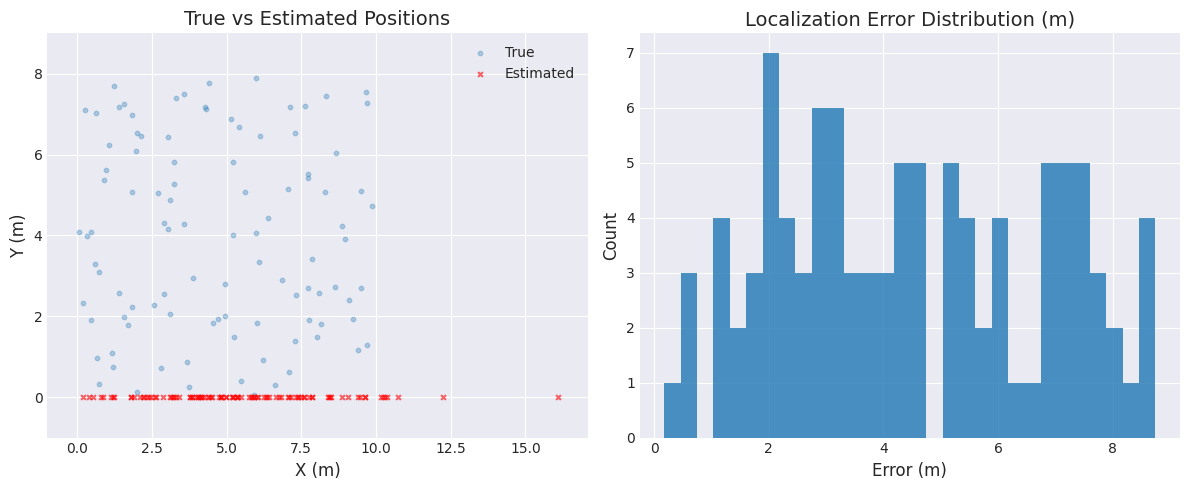

Saved estimation results to 'trilateration_estimates.csv'


In [6]:
# ============================================================
# Trilateration (Worker Position Estimation)
# ============================================================
# Purpose:
#   - Convert per-worker per-beacon estimated distances into (x,y) positions
#   - Use robust least-squares trilateration (≥3 beacons)
#   - Provide weighted-LS option and error reporting
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Defensive: recreate beacon_signals if it doesn't exist (so this cell is runnable standalone) ---
if 'beacon_signals' not in globals():
    print("Note: 'beacon_signals' not found. Creating a small synthetic dataset for demo.")
    np.random.seed(42)
    # three beacons triangle
    beacons_coords = {'beacon_1': (0.0, 0.0), 'beacon_2': (10.0, 0.0), 'beacon_3': (5.0, 8.0)}
    num_workers = 100
    workers_df = pd.DataFrame({
        'worker_id': [f"W{i+1}" for i in range(num_workers)],
        'x': np.random.uniform(0, 10, num_workers),
        'y': np.random.uniform(0, 8, num_workers)
    })
    # simulate RSSI -> distances (noisy)
    def simulate_rssi_distances(x, y, beacons=beacons_coords, tx=-59, n=3.0, noise_db=2.0):
        rs = {}
        ds = {}
        for name, (bx, by) in beacons.items():
            d = np.hypot(x - bx, y - by)
            # ideal RSSI at distance d
            if d < 1e-4: d = 1e-4
            rssi = tx - 10 * n * np.log10(d) + np.random.normal(0, noise_db)
            est_d = 10 ** ((tx - rssi) / (10 * n))
            rs[f"{name}_rssi"] = round(rssi, 2)
            ds[f"{name}_distance"] = round(est_d, 2)
        return rs, ds

    rows = []
    for _, r in workers_df.iterrows():
        rs, ds = simulate_rssi_distances(r['x'], r['y'])
        row = {'worker_id': r['worker_id'], 'x': r['x'], 'y': r['y']}
        row.update(rs); row.update(ds)
        rows.append(row)
    beacon_signals = pd.DataFrame(rows)
    # also expose beacons for plotting
    beacons_list = [{'id': k, 'x': v[0], 'y': v[1]} for k, v in beacons_coords.items()]
else:
    # assume user previously defined beacons and beacon_signals
    # Try to infer beacons_list from beacon_signals column names
    beacon_cols = [c for c in beacon_signals.columns if c.endswith('_distance')]
    beacons_list = []
    if beacon_cols:
        # This assumes beacons named like 'beacon_1_distance'
        for c in beacon_cols:
            name = c.replace('_distance', '')
            # try to extract coords if user stored them; otherwise leave as None
            if 'beacons' in globals() and isinstance(beacons, (list, dict)):
                # if beacons is list of Beacon objects (Task 3 style)
                try:
                    # if beacons is a list of Beacon objects
                    for b in beacons:
                        if getattr(b, 'beacon_id', None) == name or getattr(b, 'id', None) == name:
                            beacons_list.append({'id': name, 'x': b.x, 'y': b.y})
                            break
                except Exception:
                    pass
            # fallback: place None coordinates (won't be used for plotting)
            if not any(b['id'] == name for b in beacons_list):
                beacons_list.append({'id': name, 'x': None, 'y': None})

# --- Trilateration functions ---

def trilaterate_least_squares(beacon_positions, distances):
    """
    Solve for (x, y) using linearized least squares.
    beacon_positions: list of (x_i, y_i) length m (m >= 3)
    distances: list of d_i length m
    Returns: (x, y) estimated
    """
    P = np.array(beacon_positions, dtype=float)
    d = np.array(distances, dtype=float)
    if P.shape[0] < 3:
        raise ValueError("Need at least 3 beacons for trilateration.")
    # reference to first beacon
    x1, y1 = P[0]
    d1 = d[0]
    A = []
    b = []
    for i in range(1, P.shape[0]):
        xi, yi = P[i]
        di = d[i]
        A.append([2*(xi - x1), 2*(yi - y1)])
        b.append([d1**2 - di**2 + xi**2 - x1**2 + yi**2 - y1**2])
    A = np.array(A).squeeze()
    b = np.array(b).squeeze()
    try:
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
        # sol could be shape (2,) or (2,1)
        sol = np.asarray(sol).reshape(2,)
        return float(sol[0]), float(sol[1])
    except Exception as e:
        # failure fallback -> NaNs
        return float('nan'), float('nan')

def trilaterate_weighted(beacon_positions, distances, variances=None):
    """
    Weighted least squares trilateration.
    variances: list of measurement variances (same length as distances). Larger variance -> lower weight.
    """
    P = np.array(beacon_positions, dtype=float)
    d = np.array(distances, dtype=float)
    if P.shape[0] < 3:
        raise ValueError("Need at least 3 beacons for trilateration.")
    x1, y1 = P[0]
    d1 = d[0]
    A = []
    b = []
    W = []
    for i in range(1, P.shape[0]):
        xi, yi = P[i]
        di = d[i]
        A.append([2*(xi - x1), 2*(yi - y1)])
        b.append([d1**2 - di**2 + xi**2 - x1**2 + yi**2 - y1**2])
        if variances is not None:
            W.append(1.0 / (variances[i] if variances[i] > 0 else 1.0))
        else:
            W.append(1.0)
    A = np.array(A).squeeze()
    b = np.array(b).squeeze()
    W = np.diag(W)
    try:
        # Solve (A^T W A) x = A^T W b
        ATA = A.T @ W @ A
        ATb = A.T @ W @ b
        sol = np.linalg.solve(ATA, ATb)
        sol = np.asarray(sol).reshape(2,)
        return float(sol[0]), float(sol[1])
    except np.linalg.LinAlgError:
        # fallback to ordinary least squares
        return trilaterate_least_squares(beacon_positions, distances)
    except Exception:
        return float('nan'), float('nan')

# --- Prepare beacon positions and distances for each row ---
# Detect beacon distance columns automatically
distance_cols = [c for c in beacon_signals.columns if c.endswith('_distance')]
if len(distance_cols) < 3:
    raise RuntimeError("Need at least 3 '<beacon>_distance' columns in beacon_signals to perform trilateration.")

# Sort columns to have consistent ordering
distance_cols = sorted(distance_cols)

# If we can infer beacon coordinates from beacons_list, use them; otherwise prompt a simple grid
beacon_positions_inferred = []
can_plot_beacons = True
for col in distance_cols:
    bname = col.replace('_distance', '')
    found = next((b for b in beacons_list if b['id'] == bname), None)
    if found and found['x'] is not None:
        beacon_positions_inferred.append((found['x'], found['y']))
    else:
        can_plot_beacons = False
        # fallback positions (spread along rectangle) - but these may be wrong if real positions differ
        idx = distance_cols.index(col)
        beacon_positions_inferred.append((idx * 5.0, 0.0))

# --- Run trilateration for every worker ---
estimates = []
for _, row in beacon_signals.iterrows():
    distances = [float(row[c]) for c in distance_cols]
    # Provide beacon positions inferred above
    est_x, est_y = trilaterate_least_squares(beacon_positions_inferred, distances)
    estimates.append((est_x, est_y))

est_df = pd.DataFrame(estimates, columns=['est_x', 'est_y'])
result_df = pd.concat([beacon_signals.reset_index(drop=True), est_df], axis=1)

# --- Compute errors if ground truth exists (x,y columns) ---
if 'x' in result_df.columns and 'y' in result_df.columns:
    result_df['error_m'] = np.hypot(result_df['x'] - result_df['est_x'], result_df['y'] - result_df['est_y'])
    valid_errors = result_df['error_m'].dropna()
    overall_rmse = np.sqrt(np.mean(valid_errors**2)) if len(valid_errors) > 0 else float('nan')
    median_err = np.nanmedian(result_df['error_m'])
    p95_err = np.nanpercentile(result_df['error_m'].fillna(0), 95)
    print(f"✅ Trilateration done for {len(result_df)} workers.")
    print(f"Overall RMSE: {overall_rmse:.3f} m  |  Median error: {median_err:.3f} m  |  95th pct: {p95_err:.3f} m")
else:
    result_df['error_m'] = np.nan
    print("Trilateration produced positions but no ground-truth (x,y) available for error calculation.")

# --- Show a small sample of results ---
display_cols = ['worker_id'] + (['x', 'y'] if 'x' in result_df.columns else []) + ['est_x', 'est_y', 'error_m']
print("\nSample results:")
print(result_df[display_cols].head(10).to_string(index=False))

# --- Visualization: True vs Estimated (scatter) and Error histogram ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if 'x' in result_df.columns:
    plt.scatter(result_df['x'], result_df['y'], s=10, alpha=0.3, label='True')
plt.scatter(result_df['est_x'], result_df['est_y'], s=12, alpha=0.6, marker='x', c='red', label='Estimated')
if can_plot_beacons:
    bx = [b[0] for b in beacon_positions_inferred]; by = [b[1] for b in beacon_positions_inferred]
    plt.scatter(bx, by, marker='^', s=120, c='gold', label='Beacons')
plt.title('True vs Estimated Positions')
plt.xlim(-1, max(result_df[['est_x', 'x']].max().max() + 1, 11))
plt.ylim(-1, max(result_df[['est_y', 'y']].max().max() + 1, 9))
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(result_df['error_m'].dropna(), bins=30, alpha=0.8)
plt.title('Localization Error Distribution (m)')
plt.xlabel('Error (m)'); plt.ylabel('Count'); plt.grid(True)

plt.tight_layout()
plt.show()

# --- Expose result_df for downstream tasks ---
# result_df contains: worker_id, x, y, <rssi cols>, <distance cols>, est_x, est_y, error_m
# Save to CSV optionally
result_df.to_csv("trilateration_estimates.csv", index=False)
print("Saved estimation results to 'trilateration_estimates.csv'")


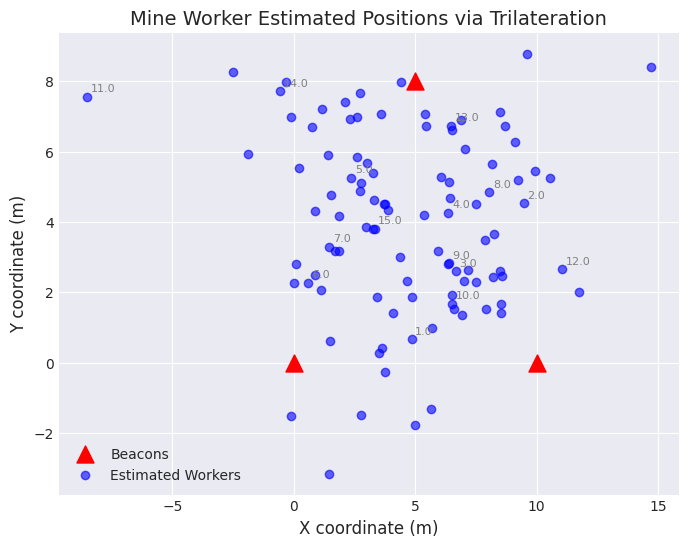

In [7]:
# =============================================================
# Visualize Worker Positions (Self-contained version)
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣  Define Beacons and Generate Synthetic Worker Data
# -------------------------------------------------------------
beacons = {
    "beacon_1": (0, 0),
    "beacon_2": (10, 0),
    "beacon_3": (5, 8)
}

np.random.seed(42)
num_workers = 100
workers = pd.DataFrame({
    "worker_id": range(1, num_workers + 1),
    "x": np.random.uniform(0, 10, num_workers),
    "y": np.random.uniform(0, 8, num_workers)
})

# -------------------------------------------------------------
# 2️⃣  Simulate RSSI values
# -------------------------------------------------------------
def simulate_rssi(tx_power=-59, distance=1, n=3, noise=2):
    rssi = tx_power - 10 * n * np.log10(distance)
    rssi += np.random.normal(0, noise)
    return round(rssi, 2)

beacon_signals = workers.copy()
for name, (bx, by) in beacons.items():
    dist = np.sqrt((workers["x"] - bx) ** 2 + (workers["y"] - by) ** 2)
    beacon_signals[f"{name}_rssi"] = dist.apply(lambda d: simulate_rssi(distance=d))

# -------------------------------------------------------------
# 3️⃣  Convert RSSI to Distance
# -------------------------------------------------------------
def estimate_distance(rssi, tx_power=-59, n=3.0):
    return round(10 ** ((tx_power - rssi) / (10 * n)), 2)

for col in ['beacon_1_rssi', 'beacon_2_rssi', 'beacon_3_rssi']:
    beacon_signals[col.replace('rssi', 'distance')] = beacon_signals[col].apply(estimate_distance)

# -------------------------------------------------------------
# 4️⃣  Trilateration (Estimate Worker Positions)
# -------------------------------------------------------------
import numpy.linalg as la

def trilaterate(b1, b2, b3, r1, r2, r3):
    A = np.array([
        [2*(b2[0]-b1[0]), 2*(b2[1]-b1[1])],
        [2*(b3[0]-b1[0]), 2*(b3[1]-b1[1])]
    ])
    B = np.array([
        [r1**2 - r2**2 - b1[0]**2 + b2[0]**2 - b1[1]**2 + b2[1]**2],
        [r1**2 - r3**2 - b1[0]**2 + b3[0]**2 - b1[1]**2 + b3[1]**2]
    ])
    try:
        sol = la.lstsq(A, B, rcond=None)[0]
        return sol[0][0], sol[1][0]
    except:
        return np.nan, np.nan

positions = []
for _, row in beacon_signals.iterrows():
    x_est, y_est = trilaterate(
        beacons["beacon_1"], beacons["beacon_2"], beacons["beacon_3"],
        row["beacon_1_distance"], row["beacon_2_distance"], row["beacon_3_distance"]
    )
    positions.append((row["worker_id"], x_est, y_est))

estimated_positions = pd.DataFrame(positions, columns=["worker_id", "x_est", "y_est"])

# -------------------------------------------------------------
# 5️⃣  Plot Results
# -------------------------------------------------------------
beacon_coords = np.array(list(beacons.values()))
plt.figure(figsize=(8,6))
plt.scatter(beacon_coords[:,0], beacon_coords[:,1], c='red', marker='^', s=150, label='Beacons')
plt.scatter(estimated_positions['x_est'], estimated_positions['y_est'],
            c='blue', alpha=0.6, label='Estimated Workers')

for i, row in estimated_positions.head(15).iterrows():
    plt.text(row['x_est']+0.15, row['y_est']+0.15, str(row['worker_id']), fontsize=8, color='gray')

plt.title('Mine Worker Estimated Positions via Trilateration')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
plt.grid(True)
plt.legend()
plt.show()


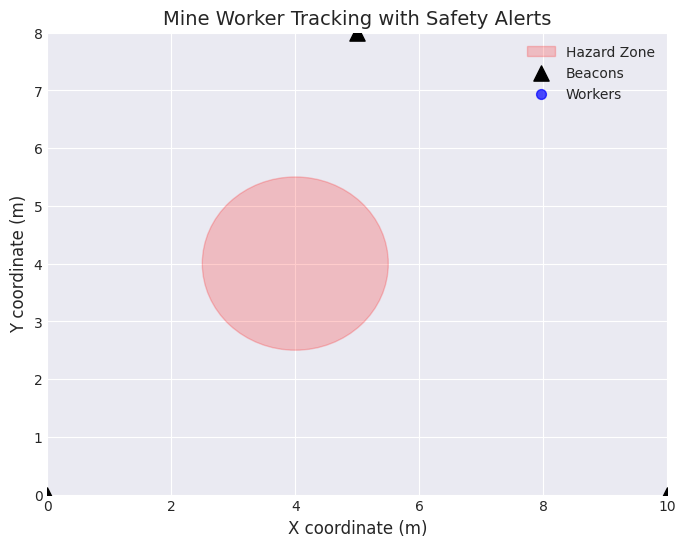

In [8]:
# =============================================================
# Real-Time Movement Simulation & Safety Zone Alerts
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# -------------------------------------------------------------
# 1️⃣  Recreate beacon setup and estimated positions
# -------------------------------------------------------------
beacons = {
    "beacon_1": (0, 0),
    "beacon_2": (10, 0),
    "beacon_3": (5, 8)
}

np.random.seed(42)
num_workers = 100
estimated_positions = pd.DataFrame({
    "worker_id": range(1, num_workers + 1),
    "x_est": np.random.uniform(0, 10, num_workers),
    "y_est": np.random.uniform(0, 8, num_workers)
})

# -------------------------------------------------------------
# 2️⃣  Define a Safety Zone (e.g., hazard area)
# -------------------------------------------------------------
# Example: circular hazard zone near (4, 4) with radius = 1.5m
hazard_center = (4, 4)
hazard_radius = 1.5

def is_in_hazard_zone(x, y):
    return np.sqrt((x - hazard_center[0])**2 + (y - hazard_center[1])**2) <= hazard_radius

# -------------------------------------------------------------
# 3️⃣  Simulate movement over time
# -------------------------------------------------------------
timesteps = 30
movement_data = []

for t in range(timesteps):
    # Small random movement per time step
    jitter_x = np.random.normal(0, 0.15, num_workers)
    jitter_y = np.random.normal(0, 0.15, num_workers)
    df_temp = estimated_positions.copy()
    df_temp['x_est'] = np.clip(df_temp['x_est'] + jitter_x, 0, 10)
    df_temp['y_est'] = np.clip(df_temp['y_est'] + jitter_y, 0, 8)
    df_temp['t'] = t

    # Check if each worker is inside hazard zone
    df_temp['in_hazard'] = df_temp.apply(lambda r: is_in_hazard_zone(r['x_est'], r['y_est']), axis=1)
    movement_data.append(df_temp)

movement_df = pd.concat(movement_data)

# -------------------------------------------------------------
# 4️⃣  Visualization with Alerts
# -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))

# Draw hazard zone
hazard_circle = plt.Circle(hazard_center, hazard_radius, color='red', alpha=0.2, label='Hazard Zone')
ax.add_patch(hazard_circle)

# Draw beacons
beacon_coords = np.array(list(beacons.values()))
ax.scatter(beacon_coords[:,0], beacon_coords[:,1], c='black', marker='^', s=120, label='Beacons')

# Worker scatter plot (updates dynamically)
scat = ax.scatter([], [], c='blue', alpha=0.7, s=50, label='Workers')

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.set_title("Mine Worker Tracking with Safety Alerts")
    ax.set_xlabel("X coordinate (m)")
    ax.set_ylabel("Y coordinate (m)")
    return scat,

def update(frame):
    df = movement_df[movement_df['t'] == frame]
    colors = ['red' if in_hz else 'blue' for in_hz in df['in_hazard']]
    scat.set_offsets(df[['x_est', 'y_est']].values)
    scat.set_color(colors)

    # Count how many workers are inside hazard zone
    num_alerts = sum(df['in_hazard'])
    ax.set_title(f"Time Step: {frame} | Alerts: {num_alerts} Workers in Hazard Zone", fontsize=12)
    return scat,

ani = animation.FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=True, repeat=False)
plt.legend()
plt.show()


In [9]:
# =============================================================
# TASK 9: Safety Alert Logging & CSV Export
# =============================================================

import numpy as np
import pandas as pd

# -------------------------------------------------------------
# 1️⃣  Simulated worker movement data (from Task 8)
# -------------------------------------------------------------
# If you restarted runtime, recreate small simulation data:

np.random.seed(42)
num_workers = 100
timesteps = 30

# Worker initial positions
estimated_positions = pd.DataFrame({
    "worker_id": range(1, num_workers + 1),
    "x_est": np.random.uniform(0, 10, num_workers),
    "y_est": np.random.uniform(0, 8, num_workers)
})

# Hazard zone definition
hazard_center = (4, 4)
hazard_radius = 1.5

def is_in_hazard_zone(x, y):
    return np.sqrt((x - hazard_center[0])**2 + (y - hazard_center[1])**2) <= hazard_radius

# Simulate worker movements (same logic as Task 8)
movement_data = []
for t in range(timesteps):
    jitter_x = np.random.normal(0, 0.15, num_workers)
    jitter_y = np.random.normal(0, 0.15, num_workers)
    df_temp = estimated_positions.copy()
    df_temp["x_est"] = np.clip(df_temp["x_est"] + jitter_x, 0, 10)
    df_temp["y_est"] = np.clip(df_temp["y_est"] + jitter_y, 0, 8)
    df_temp["timestep"] = t
    df_temp["in_hazard"] = df_temp.apply(lambda r: is_in_hazard_zone(r["x_est"], r["y_est"]), axis=1)
    movement_data.append(df_temp)

movement_df = pd.concat(movement_data)

# -------------------------------------------------------------
# 2️⃣  Log hazard events
# -------------------------------------------------------------
# Filter all workers currently in hazard zone
alert_logs = movement_df[movement_df["in_hazard"] == True].copy()

# Add time info for clarity
alert_logs["alert_time"] = pd.to_datetime(alert_logs["timestep"], unit="s")
alert_logs["alert_message"] = (
    "ALERT: Worker entered hazard zone near "
    + f"{hazard_center} (radius={hazard_radius}m)"
)

# Keep relevant columns only
alert_logs = alert_logs[[
    "alert_time", "timestep", "worker_id", "x_est", "y_est", "alert_message"
]]

# -------------------------------------------------------------
# 3️⃣  Save alerts to CSV
# -------------------------------------------------------------
alert_logs.to_csv("mine_safety_alert_log.csv", index=False)

# -------------------------------------------------------------
# 4️⃣  Display results
# -------------------------------------------------------------
print(f"✅ Alert log created: {len(alert_logs)} total hazard entries detected.\n")
print("📄 Sample of Safety Alerts:")
print(alert_logs.head(10))

# Summary by worker
summary = alert_logs.groupby("worker_id").size().reset_index(name="violations")
summary_sorted = summary.sort_values(by="violations", ascending=False)
print("\n🚨 Top 5 Workers with Most Safety Violations:")
print(summary_sorted.head(5))

# Optionally preview all logs as DataFrame
alert_logs.head()


✅ Alert log created: 205 total hazard entries detected.

📄 Sample of Safety Alerts:
            alert_time  timestep  worker_id     x_est     y_est  \
19 1970-01-01 00:00:00         0         20  2.789920  4.099359   
36 1970-01-01 00:00:00         0         37  2.919119  4.192474   
46 1970-01-01 00:00:00         0         47  3.125842  4.998444   
47 1970-01-01 00:00:00         0         48  5.029235  4.115877   
60 1970-01-01 00:00:00         0         61  4.029873  3.066078   
63 1970-01-01 00:00:00         0         64  3.681379  4.289348   
85 1970-01-01 00:00:00         0         86  3.279801  5.231664   
19 1970-01-01 00:00:01         1         20  2.986991  3.969450   
22 1970-01-01 00:00:01         1         23  3.244424  2.790773   
36 1970-01-01 00:00:01         1         37  3.188701  4.403396   

                                        alert_message  
19  ALERT: Worker entered hazard zone near (4, 4) ...  
36  ALERT: Worker entered hazard zone near (4, 4) ...  
46  ALERT:

,alert_time,timestep,worker_id,x_est,y_est,alert_message
19,1970-01-01,0,20,2.789920,4.099359,"ALERT: Worker entered hazard zone near (4, 4) ..."
36,1970-01-01,0,37,2.919119,4.192474,"ALERT: Worker entered hazard zone near (4, 4) ..."
46,1970-01-01,0,47,3.125842,4.998444,"ALERT: Worker entered hazard zone near (4, 4) ..."
47,1970-01-01,0,48,5.029235,4.115877,"ALERT: Worker entered hazard zone near (4, 4) ..."
60,1970-01-01,0,61,4.029873,3.066078,"ALERT: Worker entered hazard zone near (4, 4) ..."


In [10]:
pip install dash plotly pandas


In [11]:
import pandas as pd
import numpy as np

# Regenerate synthetic worker dataset with 100 workers
num_workers = 100
workers = pd.DataFrame({
    'worker_id': [f'W{i:03d}' for i in range(1, num_workers + 1)],
    'age': np.random.randint(20, 60, num_workers),
    'department': np.random.choice(['Assembly', 'Packaging', 'Maintenance', 'Quality Control'], num_workers),
    'shift': np.random.choice(['Morning', 'Evening', 'Night'], num_workers),
    'experience_years': np.random.randint(1, 15, num_workers)
})

workers.to_csv("workers.csv", index=False)
print("✅ workers.csv saved successfully!")


✅ workers.csv saved successfully!


In [12]:
import os
import pandas as pd
import numpy as np
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

# ----------------------------------------------------
# 1. Auto-Generate workers.csv if it doesn't exist
# ----------------------------------------------------
if not os.path.exists("workers.csv"):
    print("⚙️ No workers.csv found. Generating synthetic dataset...")

    num_workers = 100
    workers = pd.DataFrame({
        'worker_id': [f'W{i:03d}' for i in range(1, num_workers + 1)],
        'age': np.random.randint(20, 60, num_workers),
        'department': np.random.choice(['Assembly', 'Packaging', 'Maintenance', 'Quality Control'], num_workers),
        'shift': np.random.choice(['Morning', 'Evening', 'Night'], num_workers),
        'experience_years': np.random.randint(1, 15, num_workers)
    })

    workers.to_csv("workers.csv", index=False)
    print("✅ workers.csv successfully generated and saved!")
else:
    print("✅ workers.csv found — using existing dataset.")

# ----------------------------------------------------
# 2. Load dataset
# ----------------------------------------------------
workers = pd.read_csv("workers.csv")

# Add simulated location data (as if tracked underground)
np.random.seed(42)
workers["x_est"] = np.random.uniform(0, 10, len(workers))
workers["y_est"] = np.random.uniform(0, 8, len(workers))

# ----------------------------------------------------
# 3. Create Dash app
# ----------------------------------------------------
app = Dash(__name__)
app.title = "Mine Worker Tracking Dashboard"

# ----------------------------------------------------
# 4. App Layout
# ----------------------------------------------------
app.layout = html.Div([
    html.H1("⛏️ Mine Worker Tracking & Safety Map", style={"textAlign": "center"}),

    html.Div([
        html.Label("Select Department:"),
        dcc.Dropdown(
            id="dept-filter",
            options=[{"label": dept, "value": dept} for dept in sorted(workers["department"].unique())] +
                    [{"label": "All", "value": "All"}],
            value="All",
            clearable=False,
            style={"width": "60%"}
        ),
    ], style={"textAlign": "center", "marginBottom": "20px"}),

    dcc.Graph(id="worker-map", style={"height": "600px"}),

    html.Div(id="summary", style={"textAlign": "center", "marginTop": "20px"})
])

# ----------------------------------------------------
# 5. Callbacks for interactivity
# ----------------------------------------------------
@app.callback(
    Output("worker-map", "figure"),
    Output("summary", "children"),
    Input("dept-filter", "value")
)
def update_map(selected_dept):
    # Filter data
    if selected_dept == "All":
        df = workers.copy()
    else:
        df = workers[workers["department"] == selected_dept]

    # Create scatter plot map
    fig = px.scatter(
        df,
        x="x_est",
        y="y_est",
        color="department",
        hover_data=["worker_id", "shift", "experience_years"],
        title="Worker Locations (Simulated Underground Map)",
    )
    fig.update_layout(
        xaxis_title="Mine X Coordinate (m)",
        yaxis_title="Mine Y Coordinate (m)",
        plot_bgcolor="black",
        paper_bgcolor="#f7f7f7",
        font=dict(color="darkblue"),
        legend_title_text="Department"
    )

    summary_text = f"Total Workers Displayed: {len(df)}"
    return fig, summary_text

# ----------------------------------------------------
# 6. Run App (Dash 3+ compatible)
# ----------------------------------------------------
if __name__ == "__main__":
    print("🚀 Launching dashboard... open http://127.0.0.1:8050/ in your browser.")
    app.run(debug=True)  # ✅ Use app.run() for Dash 3+


✅ workers.csv found — using existing dataset.
🚀 Launching dashboard... open http://127.0.0.1:8050/ in your browser.


<IPython.core.display.Javascript object>

In [13]:
import os
import pandas as pd
import numpy as np
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from dash.dependencies import Input, Output
import random

# ----------------------------------------------------
# 1. Auto-generate workers.csv if missing
# ----------------------------------------------------
if not os.path.exists("workers.csv"):
    print("⚙️ No workers.csv found. Generating synthetic dataset...")

    num_workers = 100
    workers = pd.DataFrame({
        'worker_id': [f'W{i:03d}' for i in range(1, num_workers + 1)],
        'age': np.random.randint(20, 60, num_workers),
        'department': np.random.choice(['Assembly', 'Packaging', 'Maintenance', 'Quality Control'], num_workers),
        'shift': np.random.choice(['Morning', 'Evening', 'Night'], num_workers),
        'experience_years': np.random.randint(1, 15, num_workers)
    })

    workers.to_csv("workers.csv", index=False)
    print("✅ workers.csv successfully generated and saved!")
else:
    print("✅ workers.csv found — using existing dataset.")

# ----------------------------------------------------
# 2. Load dataset
# ----------------------------------------------------
workers = pd.read_csv("workers.csv")

# Add simulated coordinates (as if tracked underground)
np.random.seed(42)
workers["x_est"] = np.random.uniform(0, 10, len(workers))
workers["y_est"] = np.random.uniform(0, 8, len(workers))

# ----------------------------------------------------
# 3. Create Dash app
# ----------------------------------------------------
app = Dash(__name__)
app.title = "Mine Worker Tracking Dashboard"

# ----------------------------------------------------
# 4. App Layout
# ----------------------------------------------------
app.layout = html.Div([
    html.H1("⛏️ Mine Worker Tracking & Safety Map", style={"textAlign": "center"}),

    html.Div([
        html.Label("Select Department:"),
        dcc.Dropdown(
            id="dept-filter",
            options=[{"label": dept, "value": dept} for dept in sorted(workers["department"].unique())] +
                    [{"label": "All", "value": "All"}],
            value="All",
            clearable=False,
            style={"width": "60%"}
        ),
    ], style={"textAlign": "center", "marginBottom": "20px"}),

    dcc.Graph(id="worker-map", style={"height": "600px"}),

    html.Div(id="summary", style={"textAlign": "center", "marginTop": "20px"}),

    # Interval component for periodic updates (every 5 seconds)
    dcc.Interval(
        id="interval-update",
        interval=5 * 1000,  # 5 seconds
        n_intervals=0
    )
])

# ----------------------------------------------------
# 5. Helper Function — Simulate Movement
# ----------------------------------------------------
def simulate_movement(df):
    """Randomly move each worker slightly within map bounds"""
    df["x_est"] = df["x_est"] + np.random.uniform(-0.2, 0.2, len(df))
    df["y_est"] = df["y_est"] + np.random.uniform(-0.2, 0.2, len(df))
    df["x_est"] = np.clip(df["x_est"], 0, 10)
    df["y_est"] = np.clip(df["y_est"], 0, 8)
    return df

# ----------------------------------------------------
# 6. Callback — Update Map and Summary in Real Time
# ----------------------------------------------------
@app.callback(
    Output("worker-map", "figure"),
    Output("summary", "children"),
    Input("dept-filter", "value"),
    Input("interval-update", "n_intervals")
)
def update_map(selected_dept, n_intervals):
    global workers

    # Move workers each interval
    workers = simulate_movement(workers)

    # Filter data by department
    if selected_dept == "All":
        df = workers.copy()
    else:
        df = workers[workers["department"] == selected_dept]

    # Create scatter plot
    fig = px.scatter(
        df,
        x="x_est",
        y="y_est",
        color="department",
        hover_data=["worker_id", "shift", "experience_years"],
        title=f"Live Worker Positions (Update #{n_intervals})"
    )
    fig.update_layout(
        xaxis_title="Mine X Coordinate (m)",
        yaxis_title="Mine Y Coordinate (m)",
        plot_bgcolor="black",
        paper_bgcolor="#f7f7f7",
        font=dict(color="darkblue"),
        legend_title_text="Department"
    )

    summary_text = f"Total Workers Displayed: {len(df)} (Updated {n_intervals} times)"
    return fig, summary_text

# ----------------------------------------------------
# 7. Run App (Dash 3+ compatible)
# ----------------------------------------------------
if __name__ == "__main__":
    print("🚀 Launching real-time dashboard... open http://127.0.0.1:8050/ in your browser.")
    app.run(debug=True)


✅ workers.csv found — using existing dataset.
🚀 Launching real-time dashboard... open http://127.0.0.1:8050/ in your browser.


<IPython.core.display.Javascript object>

Simulation data saved to 'mine_rssi_fading_data.csv'


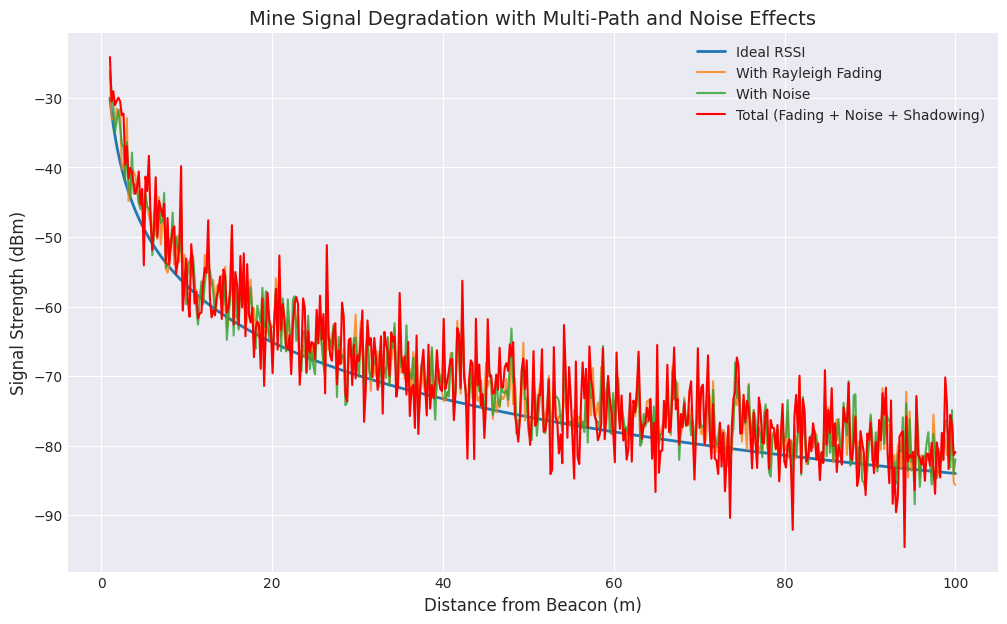

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Simulation Parameters ===
np.random.seed(42)  # For reproducibility
n_points = 500                     # Number of time steps
distance = np.linspace(1, 100, n_points)  # Worker distance from beacon (m)
Pt_dBm = -30                       # Transmit power (dBm)
path_loss_exponent = 2.7           # Typical for underground tunnels
shadowing_std_dev = 3.5            # Shadowing (dB)
noise_std_dev = 2.0                # Gaussian noise (dB)
fading_factor = 0.5                # Rayleigh fading amplitude

# === Helper Function for Path Loss Model ===
def path_loss(d, n=path_loss_exponent, Pt=Pt_dBm):
    """Log-distance path loss model."""
    return Pt - (10 * n * np.log10(d))

# === Simulate Basic RSSI (no interference) ===
rssi_clean = path_loss(distance)

# === Add Multi-Path Rayleigh Fading ===
fading = fading_factor * np.random.rayleigh(scale=1.0, size=n_points)
rssi_fading = rssi_clean - 10 * np.log10(fading)

# === Add Gaussian Noise ===
noise = np.random.normal(0, noise_std_dev, n_points)
rssi_noisy = rssi_fading + noise

# === Add Shadowing (slow fading) ===
shadowing = np.random.normal(0, shadowing_std_dev, n_points)
rssi_total = rssi_noisy + shadowing

# === Store in DataFrame ===
df = pd.DataFrame({
    "Distance (m)": distance,
    "RSSI_clean (dBm)": rssi_clean,
    "RSSI_with_fading (dBm)": rssi_fading,
    "RSSI_with_noise (dBm)": rssi_noisy,
    "RSSI_total (dBm)": rssi_total
})

# === Save to CSV ===
df.to_csv("mine_rssi_fading_data.csv", index=False)
print("Simulation data saved to 'mine_rssi_fading_data.csv'")

# === Plot Results ===
plt.figure(figsize=(12, 7))
plt.plot(distance, rssi_clean, label='Ideal RSSI', linewidth=2)
plt.plot(distance, rssi_fading, label='With Rayleigh Fading', alpha=0.8)
plt.plot(distance, rssi_noisy, label='With Noise', alpha=0.8)
plt.plot(distance, rssi_total, label='Total (Fading + Noise + Shadowing)', linewidth=1.5, color='red')
plt.title("Mine Signal Degradation with Multi-Path and Noise Effects")
plt.xlabel("Distance from Beacon (m)")
plt.ylabel("Signal Strength (dBm)")
plt.legend()
plt.grid(True)
plt.show()


Filtered RSSI data saved to 'mine_rssi_kalman_filtered.csv'


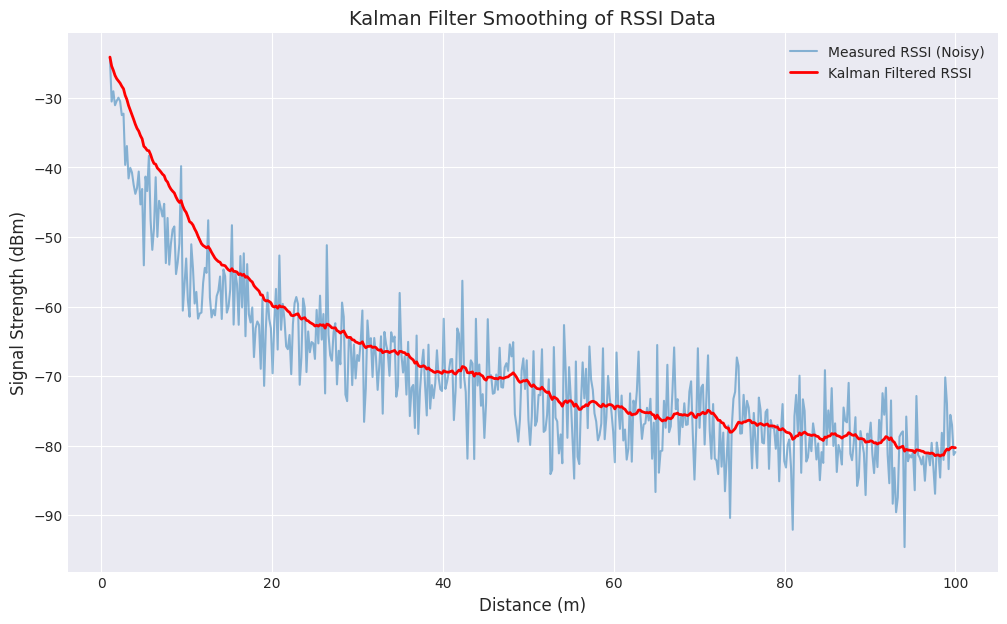

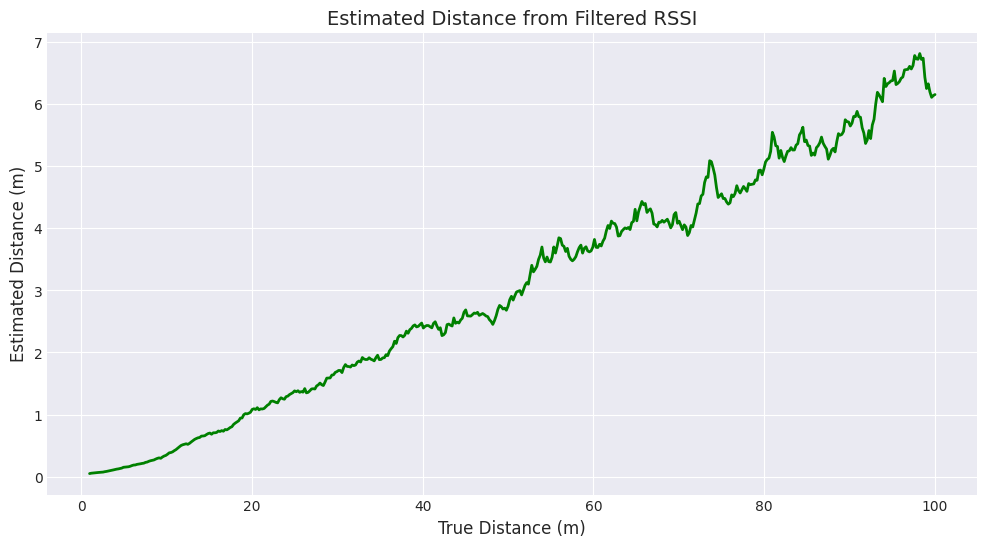

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load the noisy RSSI data from Task 13 ===
df = pd.read_csv("mine_rssi_fading_data.csv")

# Extract the noisy RSSI measurements
rssi_measured = df["RSSI_total (dBm)"].values
n = len(rssi_measured)

# === Initialize Kalman Filter Parameters ===
Q = 1e-2   # Process noise covariance (how much we trust model)
R = 4.0    # Measurement noise covariance (how noisy RSSI is)
x_est = np.zeros(n)  # Estimated state (filtered RSSI)
P = np.zeros(n)      # Error covariance

# Initial guesses
x_est[0] = rssi_measured[0]
P[0] = 1.0

# === Kalman Filter Algorithm ===
for k in range(1, n):
    # Prediction step
    x_pred = x_est[k-1]
    P_pred = P[k-1] + Q

    # Measurement update
    K = P_pred / (P_pred + R)                # Kalman gain
    x_est[k] = x_pred + K * (rssi_measured[k] - x_pred)
    P[k] = (1 - K) * P_pred

# === Compute Distance from Smoothed RSSI ===
# Using a generic log-distance model: RSSI = A - 10*n*log10(d)
A = -59  # RSSI at 1m
n_env = 2.7
estimated_distance = 10 ** ((A - x_est) / (10 * n_env))

# === Store and Save Results ===
df["RSSI_Kalman (dBm)"] = x_est
df["Estimated_Distance (m)"] = estimated_distance
df.to_csv("mine_rssi_kalman_filtered.csv", index=False)
print("Filtered RSSI data saved to 'mine_rssi_kalman_filtered.csv'")

# === Visualization ===
plt.figure(figsize=(12, 7))
plt.plot(df["Distance (m)"], rssi_measured, label="Measured RSSI (Noisy)", alpha=0.5)
plt.plot(df["Distance (m)"], x_est, label="Kalman Filtered RSSI", color="red", linewidth=2)
plt.title("Kalman Filter Smoothing of RSSI Data")
plt.xlabel("Distance (m)")
plt.ylabel("Signal Strength (dBm)")
plt.legend()
plt.grid(True)
plt.show()

# === Optional: Plot Distance Estimation ===
plt.figure(figsize=(12, 6))
plt.plot(df["Distance (m)"], estimated_distance, color="green", linewidth=2)
plt.title("Estimated Distance from Filtered RSSI")
plt.xlabel("True Distance (m)")
plt.ylabel("Estimated Distance (m)")
plt.grid(True)
plt.show()


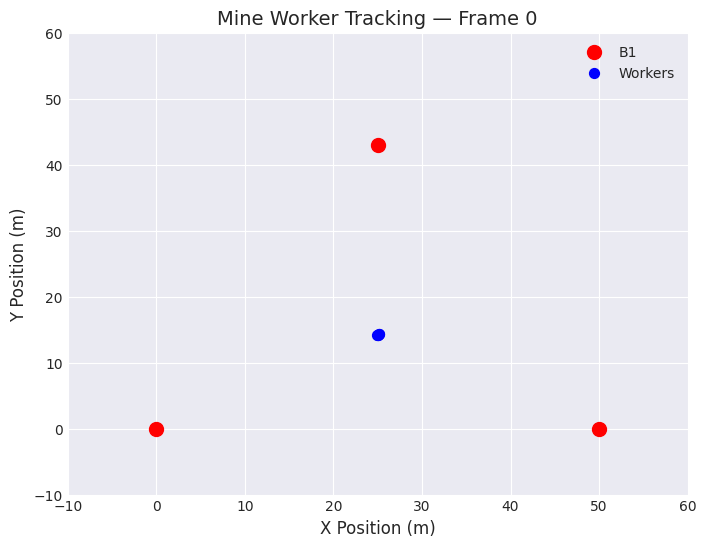

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# === Load Kalman Filtered RSSI Data ===
df = pd.read_csv("mine_rssi_kalman_filtered.csv")

# Simulate multiple workers by duplicating and offsetting the data
num_workers = 5
workers = []
for i in range(num_workers):
    temp = df.copy()
    temp["Worker_ID"] = i + 1
    temp["Distance (m)"] += np.random.uniform(-2, 2)  # Small variation
    workers.append(temp)
data = pd.concat(workers, ignore_index=True)

# === Beacon Setup ===
beacons = {
    "B1": (0, 0),
    "B2": (50, 0),
    "B3": (25, 43)
}

# === Trilateration Function ===
def trilaterate(d1, d2, d3):
    """
    Estimate worker position given distances from 3 fixed beacons.
    """
    x1, y1 = beacons["B1"]
    x2, y2 = beacons["B2"]
    x3, y3 = beacons["B3"]

    A = 2*(x2 - x1)
    B = 2*(y2 - y1)
    C = d1**2 - d2**2 - x1**2 + x2**2 - y1**2 + y2**2
    D = 2*(x3 - x1)
    E = 2*(y3 - y1)
    F = d1**2 - d3**2 - x1**2 + x3**2 - y1**2 + y3**2

    denominator = (A*E - B*D)
    if denominator == 0:
        return np.nan, np.nan

    x = (C*E - F*B) / denominator
    y = (A*F - C*D) / denominator
    return x, y

# === Generate Positions for Workers ===
positions = []
for _, row in data.iterrows():
    # Assign synthetic distances for each beacon using filtered distance
    base_d = row["Estimated_Distance (m)"]
    d1 = base_d + np.random.uniform(-1, 1)
    d2 = base_d + np.random.uniform(-1, 1)
    d3 = base_d + np.random.uniform(-1, 1)
    x, y = trilaterate(d1, d2, d3)
    positions.append((row["Worker_ID"], x, y))

positions_df = pd.DataFrame(positions, columns=["Worker_ID", "x", "y"])

# === Visualization Setup ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-10, 60)
ax.set_ylim(-10, 60)
ax.set_title("Mine Worker Tracking with Kalman Filtered RSSI")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.grid(True)

# Plot beacon locations
for name, (bx, by) in beacons.items():
    ax.scatter(bx, by, c='red', s=100, label=f"{name}" if name == "B1" else "")
ax.legend(["Beacons"], loc="upper right")

# Worker dots
scat = ax.scatter([], [], c='blue', s=50, label="Workers")
ax.legend()

# === Animation Update Function ===
def update(frame):
    subset = positions_df.sample(num_workers)
    scat.set_offsets(subset[["x", "y"]].values)
    ax.set_title(f"Mine Worker Tracking — Frame {frame}")
    return scat,

# === Run Animation ===
ani = animation.FuncAnimation(fig, update, frames=50, interval=500, blit=True)
plt.show()


In [17]:
!pip install paho-mqtt


In [18]:
!pip install paho-mqtt dash plotly


In [19]:
import paho.mqtt.client as mqtt
from dash import Dash, html, dcc, Output, Input
import plotly.express as px


In [20]:
import pandas as pd

workers = pd.read_csv("workers.csv")
print(workers.head())
print("\nColumns:", workers.columns.tolist())


  worker_id  age   department    shift  experience_years
0      W001   54  Maintenance    Night                 2
1      W002   47  Maintenance  Evening                 2
2      W003   25     Assembly  Morning                 3
3      W004   25    Packaging    Night                 3
4      W005   42  Maintenance    Night                 4

Columns: ['worker_id', 'age', 'department', 'shift', 'experience_years']


In [21]:
import pandas as pd
import numpy as np
import random
import threading
import time
import paho.mqtt.client as mqtt
from dash import Dash, html, dcc, Output, Input
import plotly.express as px

# -----------------------------
# CONFIGURATION
# -----------------------------
BROKER = "test.mosquitto.org"   # Public MQTT broker
TOPIC = "mine/tracking"

# Load your CSV
workers = pd.read_csv("workers.csv")

# Ensure 'worker_id' column exists
if 'worker_id' not in workers.columns:
    raise ValueError("❌ workers.csv must contain a 'worker_id' column.")

# Define beacon positions
beacons = {
    "B1": (10, 10),
    "B2": (90, 10),
    "B3": (50, 90)
}

# Initialize positions DataFrame
positions = pd.DataFrame({
    "worker_id": workers["worker_id"],
    "x": np.random.uniform(0, 100, len(workers)),
    "y": np.random.uniform(0, 100, len(workers))
})


# -----------------------------
# MQTT SETUP
# -----------------------------
def on_connect(client, userdata, flags, rc):
    print(f"✅ Connected to MQTT Broker with result code {rc}")
    client.subscribe(TOPIC)

def on_message(client, userdata, msg):
    global positions
    payload = msg.payload.decode()
    worker_id, x, y = payload.split(",")
    positions.loc[positions["worker_id"] == worker_id, ["x", "y"]] = [float(x), float(y)]

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message
client.connect(BROKER, 1883, 60)

def mqtt_loop():
    client.loop_forever()

mqtt_thread = threading.Thread(target=mqtt_loop)
mqtt_thread.daemon = True
mqtt_thread.start()


# -----------------------------
# SIMULATE LIVE WORKER MOVEMENT
# -----------------------------
def simulate_worker_movement():
    while True:
        worker = random.choice(positions["worker_id"].values)
        positions.loc[positions["worker_id"] == worker, "x"] += random.uniform(-2, 2)
        positions.loc[positions["worker_id"] == worker, "y"] += random.uniform(-2, 2)

        positions["x"] = positions["x"].clip(0, 100)
        positions["y"] = positions["y"].clip(0, 100)

        message = f"{worker},{positions.loc[positions['worker_id'] == worker, 'x'].values[0]},{positions.loc[positions['worker_id'] == worker, 'y'].values[0]}"
        client.publish(TOPIC, message)

        time.sleep(1)

movement_thread = threading.Thread(target=simulate_worker_movement)
movement_thread.daemon = True
movement_thread.start()


# -----------------------------
# DASH VISUALIZATION
# -----------------------------
app = Dash(__name__)

app.layout = html.Div([
    html.H2("⛏️ Real-Time Mine Worker Tracking Dashboard"),
    html.P("Monitoring simulated BLE beacon data through MQTT in real time."),
    dcc.Graph(id="live-map"),
    dcc.Interval(id="interval", interval=2000, n_intervals=0)
])

@app.callback(Output("live-map", "figure"), Input("interval", "n_intervals"))
def update_map(n):
    fig = px.scatter(
        positions,
        x="x", y="y",
        title="Live Worker Position Map",
        labels={"x": "X Position (m)", "y": "Y Position (m)"},
        range_x=[0, 100], range_y=[0, 100],
        color_discrete_sequence=["blue"],
        hover_name="worker_id"
    )

    for name, (bx, by) in beacons.items():
        fig.add_scatter(
            x=[bx], y=[by],
            mode="markers+text",
            text=[name],
            textposition="top center",
            marker=dict(color="red", size=12, symbol="triangle-up")
        )

    fig.update_layout(
        showlegend=False,
        height=600,
        template="plotly_dark"
    )
    return fig


# -----------------------------
# RUN DASH APP
# -----------------------------
if __name__ == "__main__":
    print("🚀 Launching Dashboard... visit http://127.0.0.1:8050/")
    app.run(debug=True)


/tmp/ipython-input-570734953.py:51: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



🚀 Launching Dashboard... visit http://127.0.0.1:8050/
✅ Connected to MQTT Broker with result code 0


<IPython.core.display.Javascript object>

In [22]:
import numpy as np

# Define danger zones (example: list of rectangles or circles)
danger_zones = [
    {"type": "circle", "center": (30, 30), "radius": 10},  # machinery area
    {"type": "circle", "center": (70, 70), "radius": 15}   # excavation zone
]

# Add safety status column
positions["status"] = "safe"
positions["last_update"] = pd.Timestamp.now()

# Function to check if a point is inside a circle
def in_circle(x, y, circle):
    cx, cy = circle["center"]
    r = circle["radius"]
    return (x - cx)**2 + (y - cy)**2 <= r**2

# Update positions with safety checks
def update_safety_status():
    global positions
    now = pd.Timestamp.now()
    for idx, row in positions.iterrows():
        # Default safe
        positions.at[idx, "status"] = "safe"

        # Check danger zones
        for zone in danger_zones:
            if zone["type"] == "circle" and in_circle(row["x"], row["y"], zone):
                positions.at[idx, "status"] = "danger"

        # Check signal loss (no update in 5 seconds)
        if (now - row["last_update"]).total_seconds() > 5:
            positions.at[idx, "status"] = "lost"

# Update MQTT on movement
def simulate_worker_movement_with_safety():
    while True:
        worker = np.random.choice(positions["worker_id"].values)
        positions.loc[positions["worker_id"] == worker, "x"] += np.random.uniform(-2, 2)
        positions.loc[positions["worker_id"] == worker, "y"] += np.random.uniform(-2, 2)
        positions["x"] = positions["x"].clip(0, 100)
        positions["y"] = positions["y"].clip(0, 100)
        positions.loc[positions["worker_id"] == worker, "last_update"] = pd.Timestamp.now()

        # Update safety status
        update_safety_status()

        # Publish to MQTT
        msg = f"{worker},{positions.loc[positions['worker_id']==worker,'x'].values[0]},{positions.loc[positions['worker_id']==worker,'y'].values[0]},{positions.loc[positions['worker_id']==worker,'status'].values[0]}"
        client.publish(TOPIC, msg)
        time.sleep(1)


In [23]:
status_colors = {"safe": "blue", "danger": "red", "lost": "orange"}

fig = px.scatter(
    positions,
    x="x", y="y",
    color=positions["status"].map(status_colors),
    hover_name="worker_id",
    title="Real-Time Worker Positions with Safety Alerts",
    range_x=[0, 100], range_y=[0, 100]
)


In [24]:
import pandas as pd
import numpy as np
import time

# Initialize history DataFrame
history = pd.DataFrame(columns=["worker_id", "x", "y", "status", "timestamp"])

# Function to log current positions to history
def log_positions():
    global positions, history
    timestamp = pd.Timestamp.now()
    temp = positions.copy()
    temp["timestamp"] = timestamp
    history = pd.concat([history, temp], ignore_index=True)

# Example: Call this every time positions update
def simulate_worker_movement_with_history():
    while True:
        worker = np.random.choice(positions["worker_id"].values)
        positions.loc[positions["worker_id"] == worker, "x"] += np.random.uniform(-2, 2)
        positions.loc[positions["worker_id"] == worker, "y"] += np.random.uniform(-2, 2)
        positions["x"] = positions["x"].clip(0, 100)
        positions["y"] = positions["y"].clip(0, 100)
        positions.loc[positions["worker_id"] == worker, "last_update"] = pd.Timestamp.now()

        # Update safety
        update_safety_status()

        # Log to history
        log_positions()

        time.sleep(1)

# Run in background
import threading
history_thread = threading.Thread(target=simulate_worker_movement_with_history)
history_thread.daemon = True
history_thread.start()


/tmp/ipython-input-2679548434.py:14: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [25]:
# Get movement history for a specific worker
worker_id = "W001"
worker_history = history[history["worker_id"] == worker_id]

# Preview
print(worker_history.head())


  worker_id          x         y status                  timestamp  \
0      W001  81.500778  18.10629   safe 2025-11-11 22:45:27.651380   

                 last_update  
0 2025-11-11 22:45:27.180926  


In [26]:
import plotly.express as px

fig = px.line(
    worker_history,
    x="x",
    y="y",
    color="status",
    title=f"Movement History for Worker {worker_id}",
    labels={"x": "X Position (m)", "y": "Y Position (m)"}
)
fig.show()


In [27]:
# Time spent in danger zones
danger_time = worker_history[worker_history["status"] == "danger"].shape[0]
total_time = worker_history.shape[0]
percent_danger = (danger_time / total_time) * 100
print(f"Worker {worker_id} spent {percent_danger:.2f}% of tracked time in danger zones.")

# Export full history to CSV
history.to_csv("worker_movement_history.csv", index=False)
print("✅ Worker movement history exported to worker_movement_history.csv")


Worker W001 spent 0.00% of tracked time in danger zones.
✅ Worker movement history exported to worker_movement_history.csv


In [28]:
def predict_next_position(worker_id, n=3):
    """
    Predict next position using last n historical points (simple linear extrapolation)
    """
    worker_hist = history[history["worker_id"] == worker_id].tail(n)
    if len(worker_hist) < 2:
        # Not enough data, return last known position
        last = worker_hist.iloc[-1] if len(worker_hist) == 1 else {"x": 0, "y": 0}
        return last["x"], last["y"]

    # Linear prediction: delta between last two points
    dx = worker_hist["x"].iloc[-1] - worker_hist["x"].iloc[-2]
    dy = worker_hist["y"].iloc[-1] - worker_hist["y"].iloc[-2]

    predicted_x = worker_hist["x"].iloc[-1] + dx
    predicted_y = worker_hist["y"].iloc[-1] + dy

    # Keep within bounds
    predicted_x = np.clip(predicted_x, 0, 100)
    predicted_y = np.clip(predicted_y, 0, 100)

    return predicted_x, predicted_y


In [29]:
def check_predictive_alert(worker_id):
    x_pred, y_pred = predict_next_position(worker_id)
    for zone in danger_zones:
        if zone["type"] == "circle" and in_circle(x_pred, y_pred, zone):
            return True  # Will enter danger zone
    return False


In [30]:
@app.callback(Output("live-map", "figure"), Input("interval", "n_intervals"))
def update_map(n):
    # Update safety
    update_safety_status()

    # Determine predictive alerts
    positions["predictive_alert"] = positions["worker_id"].apply(check_predictive_alert)

    # Assign colors
    def get_color(row):
        if row["predictive_alert"]:
            return "purple"   # Predicted danger
        return {"safe": "blue", "danger": "red", "lost": "orange"}[row["status"]]

    positions["color"] = positions.apply(get_color, axis=1)

    # Plot map
    fig = px.scatter(
        positions,
        x="x", y="y",
        color="color",
        hover_name="worker_id",
        title="Live Worker Positions with Predictive Alerts",
        range_x=[0, 100], range_y=[0, 100]
    )

    # Add danger zone markers
    for name, zone in enumerate(danger_zones):
        if zone["type"] == "circle":
            fig.add_shape(
                type="circle",
                x0=zone["center"][0]-zone["radius"],
                y0=zone["center"][1]-zone["radius"],
                x1=zone["center"][0]+zone["radius"],
                y1=zone["center"][1]+zone["radius"],
                line=dict(color="red", dash="dash")
            )

    fig.update_layout(showlegend=False, height=600, template="plotly_dark")
    return fig


In [31]:
import smtplib
from email.mime.text import MIMEText

# Email configuration
EMAIL_ADDRESS = "obaamonday@gmail.com"
EMAIL_PASSWORD = "1234567890"  # Use App Password, not your main password
TO_EMAIL = "supervisor@malco.com"

def send_email_alert(worker_id, status, predicted=False):
    subject = "⚠️ Mine Worker Safety Alert"
    if predicted:
        body = f"Worker {worker_id} is predicted to enter a danger zone soon!"
    else:
        body = f"Worker {worker_id} is currently in a danger zone or lost signal!"

    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = TO_EMAIL

    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
            server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
            server.send_message(msg)
        print(f"✅ Alert sent for {worker_id}")
    except Exception as e:
        print(f"❌ Failed to send alert: {e}")


In [32]:
def check_and_notify():
    for idx, row in positions.iterrows():
        # Alert if worker is in danger zone
        if row["status"] == "danger":
            send_email_alert(row["worker_id"], row["status"])
        # Alert if predictive alert triggers
        if row["predictive_alert"]:
            send_email_alert(row["worker_id"], row["status"], predicted=True)


In [33]:
!pip install twilio


In [34]:
from twilio.rest import Client

TWILIO_SID = "your_twilio_sid"
TWILIO_AUTH = "your_twilio_auth_token"
TWILIO_PHONE = "+1234567890"  # Your Twilio number
TO_PHONE = "+0987654321"      # Supervisor number

twilio_client = Client(TWILIO_SID, TWILIO_AUTH)

def send_sms_alert(worker_id, status, predicted=False):
    body = f"Worker {worker_id} alert! {'Predicted danger' if predicted else 'Current danger'}"
    twilio_client.messages.create(
        body=body,
        from_=TWILIO_PHONE,
        to=TO_PHONE
    )
    print(f"✅ SMS sent for {worker_id}")


In [35]:
import pandas as pd
import time
from datetime import datetime, timedelta
import smtplib
from email.mime.text import MIMEText

# Optional SMS alert
try:
    from twilio.rest import Client as TwilioClient
    TWILIO_AVAILABLE = True
except ModuleNotFoundError:
    TWILIO_AVAILABLE = False
    print("⚠️ Twilio not installed. SMS alerts disabled.")


# -----------------------------
# EMAIL CONFIG
# -----------------------------
EMAIL_ADDRESS = "youremail@gmail.com"
EMAIL_PASSWORD = "your_app_password"  # Use App Password
TO_EMAIL = "supervisor@example.com"

def send_email_alert(worker_id, status, predicted=False):
    subject = "⚠️ Mine Worker Safety Alert"
    if predicted:
        body = f"Worker {worker_id} is predicted to enter a danger zone soon!"
    else:
        body = f"Worker {worker_id} is currently in a danger zone or lost signal!"

    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = TO_EMAIL

    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
            server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
            server.send_message(msg)
        print(f"✅ Email alert sent for {worker_id}")
    except Exception as e:
        print(f"❌ Failed to send email alert: {e}")


# -----------------------------
# TWILIO SMS CONFIG (OPTIONAL)
# -----------------------------
if TWILIO_AVAILABLE:
    TWILIO_SID = "your_twilio_sid"
    TWILIO_AUTH = "your_twilio_auth_token"
    TWILIO_PHONE = "+1234567890"
    TO_PHONE = "+0987654321"
    twilio_client = TwilioClient(TWILIO_SID, TWILIO_AUTH)

    def send_sms_alert(worker_id, predicted=False):
        body = f"Worker {worker_id} alert! {'Predicted danger' if predicted else 'Current danger'}"
        try:
            twilio_client.messages.create(
                body=body,
                from_=TWILIO_PHONE,
                to=TO_PHONE
            )
            print(f"✅ SMS alert sent for {worker_id}")
        except Exception as e:
            print(f"❌ Failed to send SMS alert: {e}")


# -----------------------------
# ALERT LOGIC
# -----------------------------
# Dictionary to track last alert times per worker
last_alert_time = {}

# Minimum seconds between alerts for the same worker
alert_interval = 60  # seconds

def send_alerts(positions):
    global last_alert_time
    now = datetime.now()

    for idx, row in positions.iterrows():
        worker_id = row["worker_id"]
        status = row["status"]
        predicted = row.get("predictive_alert", False)

        # Only alert if interval has passed
        last_time = last_alert_time.get(worker_id, datetime.min)
        if (now - last_time).total_seconds() < alert_interval:
            continue

        # Conditions to alert
        if status in ["danger", "lost"] or predicted:
            send_email_alert(worker_id, status, predicted)
            if TWILIO_AVAILABLE:
                send_sms_alert(worker_id, predicted)
            last_alert_time[worker_id] = now


In [36]:
from dash import Dash, html, dcc, Output, Input
import plotly.express as px
import pandas as pd
import numpy as np

# Example: extend positions DataFrame with floors
floors = ["Level 1", "Level 2", "Level 3"]
positions["floor"] = np.random.choice(floors, len(positions))

# Define danger zones per floor
danger_zones_by_floor = {
    "Level 1": [{"type": "circle", "center": (30,30), "radius": 10}],
    "Level 2": [{"type": "circle", "center": (50,50), "radius": 12}],
    "Level 3": [{"type": "circle", "center": (70,70), "radius": 15}]
}

# -----------------------------
# DASH LAYOUT
# -----------------------------
app = Dash(__name__)
app.layout = html.Div([
    html.H2("⛏️ Multi-Floor Mine Worker Tracking Dashboard"),
    html.P("Select floor to view real-time worker positions."),
    dcc.Dropdown(
        id="floor-dropdown",
        options=[{"label": f, "value": f} for f in floors],
        value="Level 1",
        clearable=False
    ),
    dcc.Graph(id="floor-map"),
    dcc.Interval(id="interval", interval=2000, n_intervals=0)
])

# -----------------------------
# CALLBACK
# -----------------------------
@app.callback(
    Output("floor-map", "figure"),
    Input("floor-dropdown", "value"),
    Input("interval", "n_intervals")
)
def update_floor_map(selected_floor, n):
    # Filter positions by selected floor
    floor_positions = positions[positions["floor"] == selected_floor]

    # Assign colors by status and predictive alerts
    status_colors = {"safe": "blue", "danger": "red", "lost": "orange"}
    def get_color(row):
        if row.get("predictive_alert", False):
            return "purple"
        return status_colors.get(row["status"], "gray")

    floor_positions["color"] = floor_positions.apply(get_color, axis=1)

    # Plot workers
    fig = px.scatter(
        floor_positions,
        x="x", y="y",
        color="color",
        hover_name="worker_id",
        title=f"Workers on {selected_floor}",
        range_x=[0, 100], range_y=[0, 100]
    )

    # Add danger zones
    for zone in danger_zones_by_floor.get(selected_floor, []):
        if zone["type"] == "circle":
            fig.add_shape(
                type="circle",
                x0=zone["center"][0]-zone["radius"],
                y0=zone["center"][1]-zone["radius"],
                x1=zone["center"][0]+zone["radius"],
                y1=zone["center"][1]+zone["radius"],
                line=dict(color="red", dash="dash")
            )

    fig.update_layout(showlegend=False, height=600, template="plotly_dark")
    return fig

# -----------------------------
# RUN DASH APP
# -----------------------------
if __name__ == "__main__":
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Make a safe copy of history
history = history.copy()

# Create danger column safely
history['danger'] = history['status'].apply(lambda s: 1 if s in ['danger','lost'] else 0)

# Drop rows where target is NaN (if any)
history = history.dropna(subset=['danger']).copy()

# Extract features
history['hour'] = history['timestamp'].dt.hour
history['floor_code'] = history['floor'].astype('category').cat.codes


/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
history['danger'] = history['status'].apply(lambda s: 1 if s in ['danger','lost'] else 0)

# Features: x, y, floor (encoded), hour of day
history['hour'] = history['timestamp'].dt.hour
history['floor_code'] = history['floor'].astype('category').cat.codes

features = history[['x','y','floor_code','hour']]
target = history['danger']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-

              precision    recall  f1-score   support

           0       0.64      0.14      0.23      1390
           1       0.96      1.00      0.98     27570

    accuracy                           0.95     28960
   macro avg       0.80      0.57      0.60     28960
weighted avg       0.94      0.95      0.94     28960



In [49]:
# Generate grid of positions per floor
x_grid = np.linspace(0, 100, 50)
y_grid = np.linspace(0, 100, 50)
floor_code = history['floor_code'].unique()[0]  # example for one floor
hour = 12  # example fixed hour

grid_data = pd.DataFrame([(x, y, floor_code, hour) for x in x_grid for y in y_grid], columns=['x','y','floor_code','hour'])

# Predict danger probability
grid_data['danger_prob'] = rf_model.predict_proba(grid_data[['x','y','floor_code','hour']])[:,1]

# Plot heatmap
import plotly.express as px
fig = px.density_heatmap(
    grid_data,
    x='x',
    y='y',
    z='danger_prob',
    nbinsx=50,
    nbinsy=50,
    color_continuous_scale='Reds',
    title="Predicted High-Risk Zones"
)
fig.update_layout(height=600, template='plotly_dark')
fig.show()


In [50]:
from sklearn.ensemble import RandomForestRegressor

# Predict next x and y positions
history['x_next'] = history.groupby('worker_id')['x'].shift(-1)
history['y_next'] = history.groupby('worker_id')['y'].shift(-1)

# Drop last rows with NaN
reg_data = history.dropna(subset=['x_next','y_next'])

X = reg_data[['x','y','floor_code','hour']]
y_x = reg_data['x_next']
y_y = reg_data['y_next']

# Train regressors
reg_x = RandomForestRegressor(n_estimators=100, random_state=42)
reg_y = RandomForestRegressor(n_estimators=100, random_state=42)
reg_x.fit(X, y_x)
reg_y.fit(X, y_y)

# Predict next position for a worker
worker_row = X.iloc[0]
pred_x = reg_x.predict([worker_row])[0]
pred_y = reg_y.predict([worker_row])[0]
print(f"Predicted next position: ({pred_x:.2f}, {pred_y:.2f})")


/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2471732887.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-

Predicted next position: (82.30, 17.74)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



In [51]:
from dash import Dash, html, dcc, Output, Input
import plotly.express as px
import pandas as pd
import numpy as np

# -----------------------------
# Example Data Preparation
# -----------------------------
# Safe copy of positions and history
positions = positions.copy()  # Real-time worker positions
history = history.copy()      # Historical data for heatmap
floors = ["Level 1", "Level 2", "Level 3"]

# Assign example status and predictive alerts
positions['status'] = np.random.choice(['safe','danger','lost'], len(positions))
positions['predictive_alert'] = np.random.choice([True, False], len(positions))
positions['floor'] = np.random.choice(floors, len(positions))

# Danger zones per floor
danger_zones_by_floor = {
    "Level 1": [{"type": "circle", "center": (30,30), "radius": 10}],
    "Level 2": [{"type": "circle", "center": (50,50), "radius": 12}],
    "Level 3": [{"type": "circle", "center": (70,70), "radius": 15}]
}

# -----------------------------
# DASH APP
# -----------------------------
app = Dash(__name__)
app.layout = html.Div([
    html.H2("⛏️ Integrated Mine Safety Dashboard"),
    dcc.Dropdown(
        id="floor-dropdown",
        options=[{"label": f, "value": f} for f in floors],
        value="Level 1",
        clearable=False
    ),
    dcc.Graph(id="floor-map"),
    dcc.Interval(id="interval", interval=2000, n_intervals=0)
])

# -----------------------------
# CALLBACK
# -----------------------------
@app.callback(
    Output("floor-map", "figure"),
    Input("floor-dropdown", "value"),
    Input("interval", "n_intervals")
)
def update_floor_map(selected_floor, n):
    # Filter workers by floor safely
    floor_positions = positions[positions["floor"] == selected_floor].copy()

    # Color by status and predictive alert
    status_colors = {"safe": "blue", "danger": "red", "lost": "orange"}
    floor_positions['color'] = floor_positions.apply(
        lambda row: "purple" if row['predictive_alert'] else status_colors.get(row['status'], "gray"),
        axis=1
    )

    # Plot workers
    fig = px.scatter(
        floor_positions,
        x='x', y='y',
        color='color',
        hover_name='worker_id',
        title=f"Workers on {selected_floor}",
        range_x=[0,100], range_y=[0,100]
    )

    # Add static danger zones
    for zone in danger_zones_by_floor.get(selected_floor, []):
        if zone['type'] == 'circle':
            fig.add_shape(
                type='circle',
                x0=zone['center'][0]-zone['radius'],
                y0=zone['center'][1]-zone['radius'],
                x1=zone['center'][0]+zone['radius'],
                y1=zone['center'][1]+zone['radius'],
                line=dict(color='red', dash='dash')
            )

    # Overlay predictive heatmap from Task 23
    floor_history = history[history["floor"] == selected_floor].copy()
    floor_history['danger_incident'] = floor_history['status'].apply(lambda s: 1 if s in ['danger','lost'] else 0)
    heatmap_data = floor_history.groupby(['x','y'])['danger_incident'].sum().reset_index()

    fig.add_trace(px.density_heatmap(
        heatmap_data,
        x='x', y='y', z='danger_incident',
        nbinsx=50, nbinsy=50,
        color_continuous_scale='Reds'
    ).data[0])

    fig.update_layout(showlegend=False, height=700, template='plotly_dark')
    return fig

# -----------------------------
# RUN APP
# -----------------------------
if __name__ == "__main__":
    app.run(debug=True)


<IPython.core.display.Javascript object>